<center> <b> <font size="3"> <font color="green">rfborg </font> :
    your detector technology will be assimilated— resistance is futile! </font> </b> </center> 

- copy of phil-notebook-design.ipynb
- Simulink design : asu silver 

- vivado prj. : ~/salvation/silver_blast_bramctrl
- This design has added new BRAM controllers for DAC/DDS Waveforms for fast write times and uses URAM for SNAP blocks

In [1]:
import os
from pynq import Overlay
from pynq import Xlnk
from pynq import MMIO
import xrfclk
import xrfdc
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy import signal
# import valon_synth9 as Valon

In [2]:
# FIRMWARE UPLOAD
firmware = Overlay("bram_lutwave-sync-fixed.bit",ignore_version=True)
# firmware = Overlay("silver_blast_bramcntrlr_recompiled.bit",ignore_version=True)

# INITIALIZING LMK04208 CLOCK
clksrc = 409.6 # MHz
xrfclk.set_all_ref_clks(clksrc)

In [3]:
########################3
# Configure udp ip and mac
##########################
dst_mac_reg = firmware.IP_MAC_gpio_hier.dst_mac # 48 bits, offset 0x00 bottom 32bits, 0x08 top 16 bits
src_mac_reg = firmware.IP_MAC_gpio_hier.src_mac # 48 bits, offset 0x00 bottom 32bits, 0x08 top 16 bits
ip_reg = firmware.IP_MAC_gpio_hier.ip # offset 0x00 src ip, offset 0x08 dst ip
eth_delay_reg = firmware.eth_delay # programmable delay for eth byte shift
data_in_mux = firmware.data_in_mux
# setting ips
src_ip_int32 = int("c0a80329",16)
dst_ip_int32 = int("c0a80328",16)
src_mac0_int32 = int("deadbeef",16)
src_mac1_int16 = int("feed",16)
dst_mac0_int32 = int("5d092bb0",16) #  startech dongle 80:3f:5d:09:6b:1d
dst_mac1_int16 = int("803f",16) 

# write values
ip_reg.write( 0x00, src_ip_int32) 
ip_reg.write( 0x08, dst_ip_int32)
dst_mac_reg.write( 0x00, dst_mac0_int32)
dst_mac_reg.write( 0x08, dst_mac1_int16)
src_mac_reg.write( 0x00, src_mac0_int32)
src_mac_reg.write( 0x08, src_mac1_int16)

In [4]:
###############################
# Ethernet Delay Lines  
###############################
eth_delay_reg.write(0x00, 6 + (4<<16))#44 + (4<<16)) # data output from eth buffer delay/ input to eth buffer delay <<16 delay
eth_delay_reg.write(0x08, 3) # start pulse out delay
###############################
# Data MUX
###############################
data_in_mux.write( 0x00, 0) # coffee when 0, data when 1
data_in_mux.write( 0x08, (509) + ((8189)<<16) ) # ethernet max write count and max read count
###############################
# DDC shift
###############################

#dds_shift.write(0x00dds_shift.write(0x00,12) # 100 : for each addr in ddc bin list, 25 for bin list offs 50

# Generating DDS/DAC Waveform

In [20]:
def phase_shift(ts, phase):
    y = ts*np.exp(1j*phase)
    return ts.real + 1j*y.imag

def norm_wave(ts, max_amp=2**15-1):
    """
     Re-configure generated data values to fit LUT
    """
    Imax = max(abs(ts.real))
    Qmax = max(abs(ts.imag))
    norm = max(abs(ts))
    dacI = ((ts.real/norm)*max_amp).astype("int16")
    dacQ = ((ts.imag/norm)*max_amp).astype("int16")
    return dacI, dacQ

def surfsUpDude(freq_list, vna = False, verbose=False):
    """
    surfsUpDude Takes a list of specified frequencies and generates....stuff and things, then 
    uploads to the bram. Then we'll have totally ripped waves bruh, schralping the gnar.
    
    params
        freq_list: np.array
            list of tones to generate [Hz]
        verbose: bool
            enable / disable printing (and or) plotting of data
    """
    #####################################################
    # HARDCODED LUT PARAMS
    #####################################################
    addr_size=18   # address bit width
    channels= 2    # data points per memory address for DAC
    fs = 1024e6    # sampling rate of D/A, FPGA fabric = fs/2
    C=2            # decimation factor
    data_p = channels*2**(addr_size) # length of timestream or length of LUT+1
    
    #####################################################
    #  SET FREQ for LUT
    #####################################################
    if vna:
      N = 1000 # number of tones to make
      #freqs = -1*C*np.linspace(-250.0e6, 250.0e6,N) # equally spaced tones
      freqs_up = 1*C*np.linspace(-251e6,-1e6, N/2)
      freqs_lw = 1*C*np.linspace(2.25e6,252.25e6,N/2)
      freqs = np.append(freqs_up,freqs_lw)
      #freqs = freqs_up
    else:
      freqs = C*freq_list # equally spaced tones
    phases = np.random.uniform(-np.pi,np.pi,len(freqs))
    #phases[0] = 2*2np.arctan2(6e14,2e10)


    ######################################################
    # DAC Params
    ######################################################
    A = 2**15-1 # 16 bit D/A, expecting signed values.
    freq_res = fs/data_p # Hz
    fftbin_bw = 500e3 # Hz for effective bandwidth of 512MHz/1024 point fft on adc
    print(freq_res)
    
    ######################################################
    # GENERATE LUT WAVEFORM FROM FREQ LIST
    ######################################################
    freqs = np.round(freqs/(freq_res))*freq_res
    print("{} Frequencies Generated:".format(len(freqs)))
    print(freqs/C*1e-6)
    delta = np.zeros(data_p,dtype="complex") # empty array of deltas
    fft_bin_nums=np.zeros(len(freqs),dtype=int) # array of all dac bin index
    for i in range(len(freqs)):
        bin_num = np.round((freqs[i]/freq_res)).astype('int')
        fft_bin_nums[i]=(np.round((freqs[i]/fftbin_bw/C)).astype('int'))*C
        print("lutwaveformflist{}".format((np.round((freqs[i]/fftbin_bw/C)).astype('int'))*C))
        print(fft_bin_nums[i])
        delta[bin_num] = np.exp(1j*phases[i]) 
    ts = np.fft.ifft(delta)

    # GENERATE DDC WAVEFORM FROM BEAT FREQS
    # f_beat = (freqs/C)%(fftbin_bw)
    f_fft_bin = fft_bin_nums*fftbin_bw
    #f_beat = np.abs(freqs/C - f_fft_bin/C)
    f_beat = (freqs/C - f_fft_bin/C)
    
    if verbose:
        print("\nBeat Frequencies:")
        print(f_beat)
        print(freqs/C)

    ###########
    # new DDC
    ###########
    wave_ddc = np.zeros( int(data_p), dtype="complex") # empty array of deltas
    delta_ddc = np.zeros( shape=(len(freqs),2**9), dtype="complex") # empty array of deltas
    beat_ddc = np.zeros(shape=(len(freqs),2**9), dtype="complex")
    bin_num_ddc = np.round(f_beat*2/freq_res) # factor of 2 for half a bin width
    # bin_num_ddc = np.round(f_beat/freq_res) # removed f_beat*2
    
    print("bin num ddc "+str(bin_num_ddc))

    for i in range(len(freqs)): 
        delta_ddc[i,int(bin_num_ddc[i])] = np.exp(-1j*phases[i])
        beat_ddc[i] = np.conj(np.fft.ifft(delta_ddc[i]))
        
    for i in range(1024):
#        if (i==468): #if (i<len(freqs)):
#            wave_ddc[i::1024] = beat_ddc[0]
        if (i<len(freqs)):
            wave_ddc[i::1024] = beat_ddc[i]
        else:
            #wave_ddc[i::1024] = (1+1j)/np.sqrt(2)/2**10
            wave_ddc[i::1024] = 0 # beat_ddc[0]
            #wave_ddc[i::1024] = beat_ddc[0] #(1+1j)/np.sqrt(2)/2**10 #sets ones for arrays

#     plt.figure()
#     plt.plot(beat_ddc[0,0:100].real)
#     plt.plot(beat_ddc[0,0:100].imag)
#     plt.show()
    
    dacI, dacQ = norm_wave(ts)
    ddcI, ddcQ = norm_wave(wave_ddc, max_amp=(2**13)-1)
    
    print(len(dacI))
    ##############################
    # DDC Values
    ##############################
#     ddcQ_val = ((np.int32(ddcQ[1::2]) << 16) + ddcQ[0::2]).astype("int32")
#     ddcI_val = ((np.int32(ddcI[1::2]) << 16) + ddcI[0::2]).astype("int32")

#     dacQ_val = ((np.int32(dacQ[1::2]) << 16) + dacQ[0::2]).astype("int32")
#     dacI_val = ((np.int32(dacI[1::2]) << 16) + dacI[0::2]).astype("int32")

#     LUT_I, LUT_Q = np.zeros(data_p).astype("int32"), np.zeros(data_p).astype("int32")
#     DDS_I, DDS_Q = np.zeros(data_p).astype("int32"), np.zeros(data_p).astype("int32")

#     LUT_I = dacI_val
#     LUT_Q = dacQ_val
#     DDS_I = ddcI_val
#     DDS_Q = ddcQ_val
    return dacI, dacQ, ddcI, ddcQ, freqs

#BRAM driver code for bram v0.42
# (to be loaded into python file)




# begin new 
def load_DAC(wave_real, wave_imag):
    base_addr_DAC_I = 0x0400000000
    base_addr_DAC_Q = 0x0400100000
    mem_size = 262144*4 # 32 bit address slots
    mmio_bramI = MMIO(base_addr_DAC_I,mem_size)
    mmio_bramQ = MMIO(base_addr_DAC_Q,mem_size)
    I0, I1 = wave_real[0::2], wave_real[1::2]
    Q0, Q1 = wave_imag[0::2], wave_imag[1::2]
    dataI = ((np.int32(I1) << 16) + I0).astype("int32")
    dataQ = ((np.int32(Q1) << 16) + Q0).astype("int32")
    mmio_bramI.array[0:262144] = dataI[0:262144] # half of data
    mmio_bramQ.array[0:262144] = dataQ[0:262144]
    print("DAC waveform uploaded to AXI BRAM")
    return

def load_DDS(wave_real, wave_imag):
    
    base_addr_DDS_I = 0x0080000000
    base_addr_DDS_Q = 0x0080100000
    mem_size = 262144*4 # 32 bit address slots
    mmio_bramI = MMIO(base_addr_DDS_I,mem_size)
    mmio_bramQ = MMIO(base_addr_DDS_Q,mem_size)
    I0, I1 = wave_real[0::2], wave_real[1::2]
    Q0, Q1 = wave_imag[0::2], wave_imag[1::2]
    dataI = ((np.int32(I1) << 16) + I0).astype("int32")
    dataQ = ((np.int32(Q1) << 16) + Q0).astype("int32")
    mmio_bramI.array[0:262144] = dataI[0:262144] # half of data
    mmio_bramQ.array[0:262144] = dataQ[0:262144]
    print("DDC waveform uploaded to AXI BRAM")
    return

# end



def load_bin_list(freqs):
    #bin_list=-1*(np.round(freqs* 512/512e6))
    bin_list = np.int64( np.round(freqs/1e6) )
#    for i in range(len(freqs)):
#        if freqs[i]<0:
#            bin_list[i]=bin_list[i]-1
    print("bin_list:"+str(bin_list))
    fft_shift_and_load_bins = firmware.gpio1.axi_gpio_0 # 0x00 fft shift, 0x08 load bins
    accum_and_bin_idx = firmware.gpio2.axi_gpio_0 # 0x00 bins, 0x08 0-23 accum len, 24 accum rst, 25 sync in
    
  
    
    # initialization 
    sync_in = 2**26
#     fft_shift=0
#     if len(freqs)<400:
#         fft_shift = 1*((2**9)-1) #(2**7)-1 # CHANGED FOR NEW GPIO
#     else:
#         fft_shift = 1*((2**5)-1) #(2**7)-1 # CHANGED FOR NEW GPIO
    accum_rst = 2**24  # (active low)
    accum_length = (2**19)-1
    
    #fft_shift_and_load_bins.write(0x00, fft_shift+2**10) # enable DAC/DDS counter
    #accum_and_bin_idx.write(0x08, accum_length)
    ################################################
    # Load DDC bins
    ################################################
    #offs=60
    offs=20#12
    
    # only write tones to bin list
    for addr in range(1024):
         if ((offs-1)<addr<((offs)+len(bin_list))):
             print("addr = {}, bin# = {}".format(addr, bin_list[addr-offs]))
             accum_and_bin_idx.write(0x00, int(bin_list[addr-offs])) #110 # write bin for address single address
             fft_shift_and_load_bins.write(0x08,(addr<<1)+1) # enable we
             fft_shift_and_load_bins.write(0x08,0) # disable we
         else:
             accum_and_bin_idx.write(0x00,0)#0) #110 # write bin for address single address
             fft_shift_and_load_bins.write(0x08,(addr<<1)+1) # enable we
             fft_shift_and_load_bins.write(0x08,0) # disable we
                
                
    # write all tones to bin list 
#     for addr in range(1024):
#         x=int(addr)
#         print("addr = {}, bin# = {}".format(addr, x))
#         accum_and_bin_idx.write(0x00, x ) #110 # write bin for address single address
#         fft_shift_and_load_bins.write(0x08,(addr<<1)+1) # enable we
#         fft_shift_and_load_bins.write(0x08,0) # disable we

    ##################################################33
    # sync low
    #accum_and_bin_idx.write( 0x08, accum_length) # sync low
    return

def load_waveform_into_mem(freqs, dac_r,dac_i,dds_r,dds_i):
    #######################################################
    # Load configured LUT values into FPGA memory
    #######################################################
    
    # Arming DDC Waveform
    ########################
    # initialization 
    
    
    sync_in = 2**26
    accum_rst = 2**24  # (active redge)
    accum_length = (2**19)-1 # (2**18)-1
    
    fft_shift=0
    if len(freqs)<400:
        fft_shift = 1*((2**9)-1) #(2**7)-1 # CHANGED FOR NEW GPIO
    else:
        fft_shift = 1*((2**5)-1) #(2**7)-1 # CHANGED FOR NEW GPIO
    
    
    fft_shift_and_load_bins = firmware.gpio1.axi_gpio_0
    dds_shift=firmware.gpio3.axi_gpio_0 # DDS SHIFT offset = 0x00, 0x08 is open
    dds_shift.write(0x00,234) # WRITING TO DDS SHIFT 
    accum_and_bin_idx = firmware.gpio2.axi_gpio_0 # 0x00 bins, 0x08 0b-23b accum len, 24b accum rst, 26b sync in
    accum_and_bin_idx.write(0x08,1*accum_length) #100
    
    # accum reset low then high
    fft_shift_and_load_bins.write(0x00,2**11) # reset DAC/DDS counter

    accum_and_bin_idx.write(0x08,1*accum_length+0*sync_in+1*accum_rst) # 101 

    load_DAC(dac_r,dac_i)
    load_DDS(dds_r,dds_i)
    sleep(.5)
    fft_shift_and_load_bins.write(0x00, fft_shift+2**10) # enable DAC/DDS counter
    ########################
    accum_and_bin_idx.write(0x08,1*accum_length+1*sync_in+0*accum_rst) # 110 -- STARTS DSP FIRMWARE
    sleep(0.5)
    accum_and_bin_idx.write(0x08,1*accum_length+1*sync_in+1*accum_rst) #111
    
    return 0

In [21]:
# ADC
bram_ADC_I = firmware.ADC_I.BRAM_SNAP_0 
bram_ADC_Q = firmware.ADC_Q.BRAM_SNAP_0
def get_snap_data(snap):
  snap.write(0x04,0)       #
  snap.write(0x04,2**31)   # toggling sync clear
  snap.write(0x04,2**29)   # 
  d = np.zeros(2**11)    # bram data
    
  for i in range(2**11):
    snap.write(0x00,i<<(32-11)) # write address space to read
    for j in range(1):
      snap.write(0x04,j<<19)
      data = snap.read(0x08)
      d[i*1+j]= data
      #print(str(i*8+j))
  snap_data = np.array(d).astype("int32")
  snap_data_0 = ((snap_data >> 16).astype("int16"))#.astype('float') # decoding concatenated values
  snap_data_1 = ((snap_data & (2**(16)-1)).astype("int16"))#.astype('float') 
  d2 = np.zeros(2*2**11)# bram data
  d2[0::2]=snap_data_1
  d2[1::2]=snap_data_0
  return d2

# PFB
pfbIQ=firmware.PFB_SNAP_SYNC.BRAM_SNAPIII_v1_0_0
def get_pfb_data(snap): # make sure to toggle sync (gpio) first
  snap.write(0x04,0)       #
  snap.write(0x04,2**31)   # toggling sync clear
  snap.write(0x04,2**29)       # 

  d = np.zeros(4*2**11)# bram data 
    
  for i in range(2**11):
    snap.write(0x00,i<<(32-11)) # write address space to read
    for j in range(4):
      snap.write(0x04,j<<19)
      data = snap.read(0x08)
      d[i*4+j]= data

  snap_data = np.array(d).astype("uint32")

  snap_data=snap_data<<14
  return snap_data

def get_ddc_data(snap):
  snap.write(0x04,0)       #
  snap.write(0x04,2**31)   # toggling sync clear
  snap.write(0x04,2**29)       # 

  d = np.zeros(4*2**11)# bram data 
    
  for i in range(2**11):
    snap.write(0x00,i<<(32-11)) # write address space to read
    for j in range(4):
      snap.write(0x04,j<<19)
      data = snap.read(0x08)
      d[i*4+j]= data

  snap_data = np.array(d).astype("uint32")

  #snap_data=snap_data<<13
  return snap_data<<13

# DDC
ddc_snap = firmware.DDC_SNAP_SYNC.BRAM_SNAPIII_v1_0_0
def get_accum_data(snap,slp=.3):
  snap.write(0x04,0)       #
  snap.write(0x04,(2**29) + (2**31))   # toggling sync clear
  snap.write(0x04,2**29)       # 
  sleep(slp)

  d = np.zeros(4*2**11)# bram data 
    
  for i in range(2**11):
    snap.write(0x00,i<<(32-11)) # write address space to read
    for j in range(4):
      snap.write(0x04,j<<19)
      data = snap.read(0x08)
      d[i*4+j]= data
  snap_data = np.array(d)#.astype("int32")
  return snap_data

In [22]:
LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.linspace(20.2e6,50.0e6,1), vna=False, verbose=True)
load_bin_list(freqs)
load_waveform_into_mem(freqs, LUT_I, LUT_Q, DDS_I, DDS_Q)

1953.125
1 Frequencies Generated:
[20.20019531]
lutwaveformflist80
80

Beat Frequencies:
[200195.3125]
[20200195.3125]
bin num ddc [205.]
524288
bin_list:[40]
addr = 20, bin# = 40
DAC waveform uploaded to AXI BRAM
DDC waveform uploaded to AXI BRAM


0

In [8]:
# for n in range(1024):
#     plt.plot(DDS_Q[n::1024])
# plt.show()

# ADC DATA

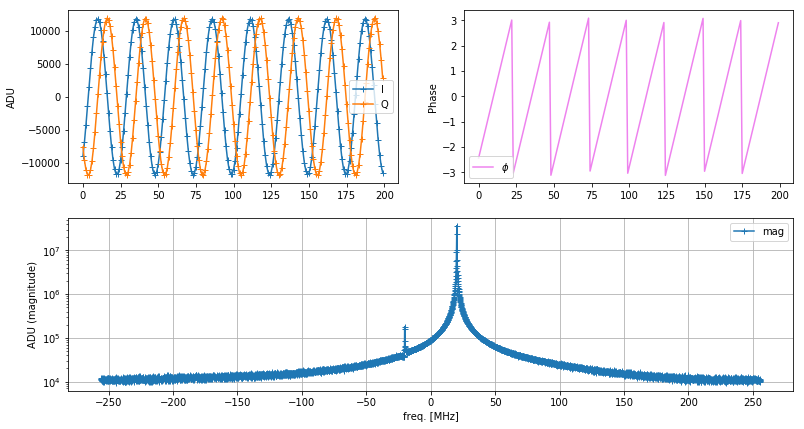

In [23]:
Q3=get_snap_data(bram_ADC_Q) # Q must run first, I is dependent on Q triggering!!!
I3=get_snap_data(bram_ADC_I)

plt.figure(figsize=(13,7))
c = slice(0,200)

plt.subplot(221)
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
#print(np.max(I3[c]))
plt.ylabel("ADU")
plt.legend()

plt.subplot(222)
plt.plot(np.arctan2(Q3[c],I3[c]),color="violet",label=r'$\phi$')
plt.ylabel("Phase")
plt.legend()

plt.subplot(2,2,(3,4))
spec=np.fft.fft(I3+1j*Q3)
spec_freqs = np.fft.fftfreq(len(I3),1/512e6)
spec=abs(spec) 
plt.semilogy(np.fft.fftshift(spec_freqs)*1e-6,np.fft.fftshift(spec),"-+",label="mag")
plt.ylabel("ADU (magnitude)"); plt.xlabel("freq. [MHz]")
plt.xticks(np.linspace(-250,250,11,dtype="int32"))
plt.grid()
plt.legend()
plt.show()

In [10]:
np.sort((1,4,2))
lmag = np.max(spec[401:])
umag = spec[np.argmax(spec)]
old_diff = umag-lmag
print(2.*np.arctan(lmag/umag) )
print(2.*np.arctan(umag/lmag) )
print(old_diff)
print(umag-lmag)

0.010396919083294914
3.1311957345064982
36666468.98328185
36666468.98328185


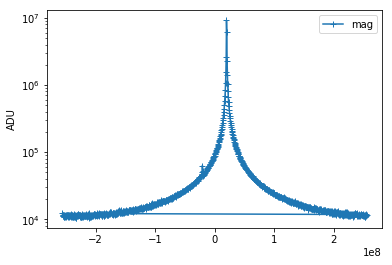

In [11]:
plt.figure()
spec=np.fft.fft(I3[0:1024]+1j*Q3[0:1024])
spec_freqs = np.fft.fftfreq(len(I3[0:1024]),1/512e6)
spec=abs(spec)
plt.semilogy(spec_freqs,spec,"-+",label="mag")
plt.ylabel("ADU")
plt.legend()
plt.show()

## Polyphase Filterbank Snap

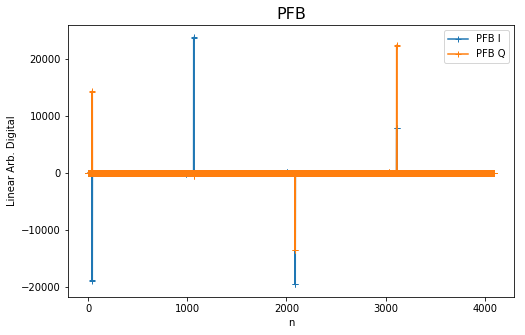

2.23606797749979
40


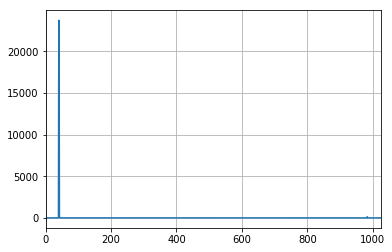

In [12]:
IQpfb_dat = get_pfb_data(pfbIQ).astype("int32")

Ipfb_f = IQpfb_dat[0::2].astype("float")/2**14
Qpfb_f = IQpfb_dat[1::2].astype("float")/2**14

SPECpfb = Ipfb_f + 1j*Qpfb_f
mag = abs(SPECpfb)

plt.figure(figsize=(8,5))
#plt.title(r"$f_s=2048MHZ, N_{bins}=512$"+"(7 tones, external hardware loopback)")
plt.xlabel("n"); plt.ylabel("Linear Arb. Digital")
#plt.plot(mag)
plt.plot(Ipfb_f,"-+",label='PFB I')
plt.plot(Qpfb_f,"-+",label='PFB Q')
plt.title("PFB",fontsize=16)
#plt.xlim(0,1024)
#plt.plot(Qpfb_f,"-+",label='Q')
plt.legend()
#plt.savefig("pfb_snap_single_tone.png",dpi=300)
plt.show()
print(mag[0])


plt.figure()
#plt.plot(abs(Ipfb_f[0:1024]))
plt.plot(mag[:])
print(np.argmax(mag[:1020]))
plt.xlim(0,1024)
plt.grid()
#plt.plot(mag[2048:3072])

In [13]:
mag[40]

23735.38455555334

# Digital Down Conversion

In [25]:
dds_shift=firmware.gpio3.axi_gpio_0


2025.1698694183656


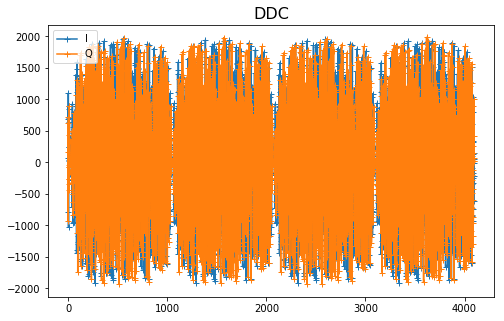

[-1857. -1822. -1825. -1809.]


In [28]:
#dds_shift.write(0x00,234) # WRITING TO DDS SHIFT 
sleep(.01)
ddc_IQ_dat = get_ddc_data(ddc_snap).astype("int32")

#Iddc_f = ddc_IQ_dat[0::2][0:1024].astype("float")
#Qddc_f = ddc_IQ_dat[1::2][0:1024].astype("float")
Iddc_f = ddc_IQ_dat[0::2].astype("float")/2**13
Qddc_f = ddc_IQ_dat[1::2].astype("float")/2**13

# roll array by 21 to line up with fft bins
#Iddc_f = np.roll(Iddc_f,-21)
#Qddc_f = np.roll(Qddc_f,-21)
IQddc=abs(Iddc_f+1j*Qddc_f)
print(IQddc[np.argmax(IQddc[:1024])])

plt.figure(figsize=(8,5))
plt.title("DDC",fontsize=16)
plt.plot(Iddc_f,"-+",label='I')
plt.plot(Qddc_f,"-+",label='Q')
#plt.xlim(0,1024)
plt.legend()
plt.show()
print(Iddc_f[np.argmax(abs(IQddc[:1024]))::1024])

In [24]:
#LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.linspace(-20.2e6,50.0e6,1), vna=False, verbose=True)
LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.array([20.2e6,31.13e6,42.33e6,63.11e6,85.03e6]), vna=True, verbose=True)
load_bin_list(freqs)
load_waveform_into_mem(freqs, LUT_I, LUT_Q, DDS_I, DDS_Q)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


1953.125
1000 Frequencies Generated:
[-251.         -250.49902344 -249.99804688 -249.49707031 -248.99609375
 -248.49511719 -247.99414062 -247.49316406 -246.9921875  -246.49121094
 -245.99023438 -245.48925781 -244.98828125 -244.48730469 -243.98632812
 -243.48535156 -242.984375   -242.48339844 -241.98242188 -241.48144531
 -240.97949219 -240.47851562 -239.97753906 -239.4765625  -238.97558594
 -238.47460938 -237.97363281 -237.47265625 -236.97167969 -236.47070312
 -235.96972656 -235.46875    -234.96777344 -234.46679688 -233.96582031
 -233.46484375 -232.96386719 -232.46289062 -231.96191406 -231.4609375
 -230.95996094 -230.45898438 -229.95800781 -229.45703125 -228.95605469
 -228.45507812 -227.95410156 -227.453125   -226.95214844 -226.45117188
 -225.95019531 -225.44921875 -224.94824219 -224.44726562 -223.94628906
 -223.4453125  -222.94433594 -222.44335938 -221.94140625 -221.44042969
 -220.93945312 -220.43847656 -219.9375     -219.43652344 -218.93554688
 -218.43457031 -217.93359375 -217.4326171

-424
lutwaveformflist-422
-422
lutwaveformflist-420
-420
lutwaveformflist-418
-418
lutwaveformflist-416
-416
lutwaveformflist-414
-414
lutwaveformflist-412
-412
lutwaveformflist-410
-410
lutwaveformflist-408
-408
lutwaveformflist-406
-406
lutwaveformflist-404
-404
lutwaveformflist-402
-402
lutwaveformflist-400
-400
lutwaveformflist-398
-398
lutwaveformflist-396
-396
lutwaveformflist-394
-394
lutwaveformflist-392
-392
lutwaveformflist-390
-390
lutwaveformflist-388
-388
lutwaveformflist-386
-386
lutwaveformflist-384
-384
lutwaveformflist-382
-382
lutwaveformflist-380
-380
lutwaveformflist-378
-378
lutwaveformflist-376
-376
lutwaveformflist-374
-374
lutwaveformflist-372
-372
lutwaveformflist-370
-370
lutwaveformflist-368
-368
lutwaveformflist-366
-366
lutwaveformflist-364
-364
lutwaveformflist-362
-362
lutwaveformflist-360
-360
lutwaveformflist-358
-358
lutwaveformflist-356
-356
lutwaveformflist-354
-354
lutwaveformflist-352
-352
lutwaveformflist-350
-350
lutwaveformflist-348
-348
lutwave

634
lutwaveformflist636
636
lutwaveformflist638
638
lutwaveformflist640
640
lutwaveformflist642
642
lutwaveformflist644
644
lutwaveformflist646
646
lutwaveformflist648
648
lutwaveformflist650
650
lutwaveformflist652
652
lutwaveformflist654
654
lutwaveformflist656
656
lutwaveformflist658
658
lutwaveformflist660
660
lutwaveformflist662
662
lutwaveformflist664
664
lutwaveformflist666
666
lutwaveformflist668
668
lutwaveformflist670
670
lutwaveformflist672
672
lutwaveformflist674
674
lutwaveformflist676
676
lutwaveformflist678
678
lutwaveformflist680
680
lutwaveformflist682
682
lutwaveformflist684
684
lutwaveformflist686
686
lutwaveformflist688
688
lutwaveformflist690
690
lutwaveformflist692
692
lutwaveformflist694
694
lutwaveformflist696
696
lutwaveformflist698
698
lutwaveformflist700
700
lutwaveformflist702
702
lutwaveformflist704
704
lutwaveformflist706
706
lutwaveformflist708
708
lutwaveformflist710
710
lutwaveformflist712
712
lutwaveformflist714
714
lutwaveformflist716
716
lutwaveformf

bin num ddc [   0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
   12.   13.   14.   15.   16.   17.   18.   19.   21.   22.   23.   24.
   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.   36.
   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.   48.
   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   60.   61.
   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.   72.   73.
   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.   84.   85.
   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.   96.   97.
   99.  100.  101.  102.  103.  104.  105.  106.  107.  108.  109.  110.
  111.  112.  113.  114.  115.  116.  117.  118.  119.  120.  121.  122.
  123.  124.  125.  126.  127.  128.  129.  130.  131.  132.  133.  134.
  135.  136.  137.  139.  140.  141.  142.  143.  144.  145.  146.  147.
  148.  149.  150.  151.  152.  153.  154.  155.  156.  157.  158.  159.
  160.  161.  162.  163.  164.  165.  1

addr = 637, bin# = 122
addr = 638, bin# = 123
addr = 639, bin# = 124
addr = 640, bin# = 125
addr = 641, bin# = 126
addr = 642, bin# = 127
addr = 643, bin# = 128
addr = 644, bin# = 129
addr = 645, bin# = 130
addr = 646, bin# = 131
addr = 647, bin# = 132
addr = 648, bin# = 133
addr = 649, bin# = 134
addr = 650, bin# = 135
addr = 651, bin# = 136
addr = 652, bin# = 137
addr = 653, bin# = 138
addr = 654, bin# = 139
addr = 655, bin# = 140
addr = 656, bin# = 141
addr = 657, bin# = 142
addr = 658, bin# = 143
addr = 659, bin# = 144
addr = 660, bin# = 145
addr = 661, bin# = 146
addr = 662, bin# = 147
addr = 663, bin# = 148
addr = 664, bin# = 149
addr = 665, bin# = 150
addr = 666, bin# = 151
addr = 667, bin# = 152
addr = 668, bin# = 153
addr = 669, bin# = 154
addr = 670, bin# = 155
addr = 671, bin# = 156
addr = 672, bin# = 157
addr = 673, bin# = 158
addr = 674, bin# = 159
addr = 675, bin# = 160
addr = 676, bin# = 161
addr = 677, bin# = 162
addr = 678, bin# = 163
addr = 679, bin# = 164
addr = 680,

DDC waveform uploaded to AXI BRAM


0

In [17]:
for step in range(512):
    dds_shift.write(0x00,step) # WRITING TO DDS SHIFT 
    sleep(.01)
    ddc_IQ_dat = get_ddc_data(ddc_snap).astype("int32")
    Iddc_f = ddc_IQ_dat[0::2].astype("float")/2**13
    Qddc_f = ddc_IQ_dat[1::2].astype("float")/2**13
    IQddc=abs(Iddc_f+1j*Qddc_f)
#    print(step, IQddc[np.argmax(IQddc[:1024]]))
    peak=IQddc[np.argmax(IQddc[:1024])]
#    if peak<100:
#        if np.std(Iddc_f[peak::1024])<50:
    print(step, peak)
#            plt.plot(Iddc_f,"-+",label='I')
#            plt.plot(Qddc_f,"-+",label='Q')
#            plt.show()

0 1985.8924945726544
1 2382.991817023298
2 1847.9307346326593
3 2349.914466528516
4 2347.443077052136
5 2258.050708022298
6 1882.0951091801924
7 1888.4758404597078
8 1907.5953449303654
9 1867.7647068086494
10 1917.7679734524716
11 1895.9338068614104
12 1877.2618357597323
13 1882.4252973225791
14 1893.0359214763992
15 2043.3044315519899
16 2032.237190881025
17 1926.5806497523015
18 1899.1419114958208
19 2041.2116499765525
20 1898.0458371704303
21 1890.2309382718292
22 1898.6956048824677
23 2340.5821925324476
24 1897.5955838903083
25 1909.4661557618663
26 2276.6334795043317
27 1876.3669683726582
28 1897.1149148114355
29 2123.654397495035
30 2015.5299551234657
31 1872.404069638816
32 1870.9743450940207
33 2052.863609692568
34 1892.8285712129348
35 1879.906912589025
36 1875.326638215327
37 1884.6562020697568
38 1983.056731412392
39 1878.8264954486883
40 1894.3803736314414
41 1898.6416196849789
42 1881.5918792341765
43 1887.105985364892
44 2019.3456861072598
45 1882.2892976373212
46 2275.01

KeyboardInterrupt: 

In [ ]:
for step in range(512):
    dds_shift.write(0x00,step) # WRITING TO DDS SHIFT 
    sleep(.01)
    ddc_IQ_dat = get_ddc_data(ddc_snap).astype("int32")
    Iddc_f = ddc_IQ_dat[0::2].astype("float")#/2**13
    Qddc_f = ddc_IQ_dat[1::2].astype("float")#/2**13
    peak=np.argmax(abs(Iddc_f[:1024]))
    if peak<100:
        if np.std(Iddc_f[peak::1024])<50:
            print(step)
            print(peak)
            plt.plot(Iddc_f,"-+",label='I')
            plt.plot(Qddc_f,"-+",label='Q')
            plt.show()

In [ ]:
plt.figure()
#plt.plot(abs(Iddc_f[0:1024]+1j*Qddc_f[0:1024]))
Xabs=abs(Iddc_f+1j*Qddc_f)
plt.plot(Xabs,"-+")
plt.grid()
plt.xlim(0,1024)
plt.show()

## Vector Accumulate and Downsample

In [29]:
accum_snap = firmware.ACCUM_SNAP_SYNC.BRAM_SNAPIII_v1_0_0

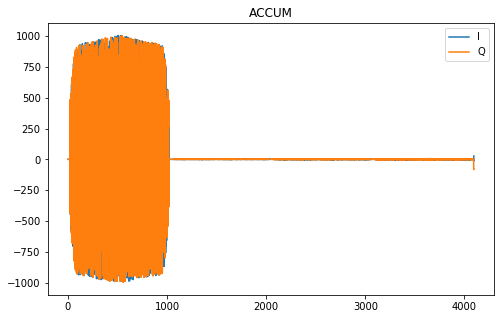

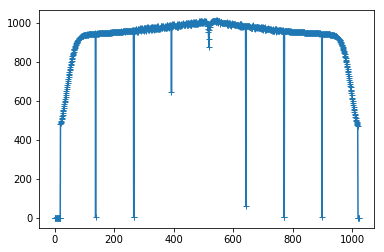

541

In [30]:
accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
Iacc_f = accum_IQ_dat[0::2]/2**10#.astype("float")
Qacc_f = accum_IQ_dat[1::2]/2**10#.astype("float")
Ia, Qa = np.array(Iacc_f).astype(float), np.array(Qacc_f).astype(float)
IQMAG=np.sqrt(Ia**2+Qa**2)

plt.figure(figsize=(8,5))
plt.plot(Ia,label='I')
plt.plot(Qa,label='Q')
plt.legend()
plt.title("ACCUM")
#plt.xlim(0,1024)
plt.show()

plt.figure()

plt.plot(IQMAG[0:1024][:],"-+")
#plt.xlim(175,225)
plt.show()
np.argmax(IQMAG)

In [ ]:
IQMAGs=[]
for _ in range(4):
    LUT_I, LUT_Q, DDS_I, DDS_Q, freqs, ddcI, ddcQ = surfsUpDude(np.linspace(20.14,200.17,1)*1e6, vna=False, verbose=False)
    load_bin_list(freqs)
    load_waveform_into_mem(LUT_I, LUT_Q, DDS_I, DDS_Q)
    sleep(1)
    
    accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
    accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
    accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
    
    Iacc_f = accum_IQ_dat[0::2]#.astype("float")
    Qacc_f = accum_IQ_dat[1::2]#.astype("float")
    Ia, Qa = np.array(Iacc_f).astype(float), np.array(Qacc_f).astype(float)
    IQMAG=np.sqrt(Ia**2+Qa**2)
    print("ACCUM Peak:"); print(np.argmax(IQMAG)); print()
    IQMAGs.append(np.argmax(IQMAG))
IQMAGs

In [ ]:
IQMAGs

In [ ]:
Is=[]
Qs=[]
xs=[]
for _ in range(150):
    x=get_accum_data(accum_snap).astype("int32")
    I=x[::2]
    Q=x[1::2]
    #print(x[150:155])
    Is.append(I)
    Qs.append(Q)
    xs.append(x)

In [ ]:
plt.plot([I[60] for I in Is],'x'); 
plt.plot([Q[60] for Q in Qs],'x'); 
#plt.show()
plt.plot([I[61] for I in Is],'x'); 
plt.plot([Q[61] for Q in Qs],'x'); 
#plt.show()
plt.plot([I[59] for I in Is],'x'); 
plt.plot([Q[59] for Q in Qs],'x'); 
plt.show()

In [ ]:
accum_IQ_dat[0:10]

In [ ]:
# mag_shift = np.zeros(1024)
l=2
for j in range(10):
    print("run {}".format(j))
    print("="*25)
    shiftmax=0
    for i in range(0, 512):
        dds_shift.write(0x00,i)
        sleep(0.75)
        #if i%50 == 0:
        #  print(i)
        accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
        Iacc_f = accum_IQ_dat[0::2][1024*l:1024*(l+1)].astype("float")
        Qacc_f = accum_IQ_dat[1::2][1024*l:1024*(l+1)].astype("float")
        MAG =  np.max(np.sqrt(Iacc_f**2+Qacc_f**2))
        #print(MAG)
        if MAG > shiftmax:
            shiftmax=MAG
            print("shift: {} maxshift: {}".format(i, shiftmax))

In [ ]:
 dds_shift.write(0x00,270) # 451 ,133  233

In [ ]:
# shift: 0 maxshift: 85817.82468112321
# shift: 77 maxshift: 89913.91105385195
# shift: 101 maxshift: 94725.08662967799
# shift: 175 maxshift: 97788.40938475275
# shift: 207 maxshift: 106220.30252734173
# shift: 246 maxshift: 112771.61490818512
# shift: 521 maxshift: 112940.4150913215
# shift: 563 maxshift: 114827.0322049647
# shift: 655 maxshift: 116114.17238649208

In [ ]:
(400e6)/900

In [ ]:
#114

# 40-60
# 210-260
# 340 - 400

In [ ]:
l=2
shiftmax=0
# kN=1
for i in range(0,512):
        dds_shift.write(0x00,i)
        sleep(1)
        if i%1 == 0:
          print(i)
#         accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
#         Iacc_f = accum_IQ_dat[0::2][1024*l:1024*(l+1)].astype("float")
#         Qacc_f = accum_IQ_dat[1::2][1024*l:1024*(l+1)].astype("float")
#         MAG =  np.max(np.sqrt((Iacc_f**2+Qacc_f**2))
#         #print(MAG)
#         if MAG > shiftmax:
#             shiftmax=MAG
#             print("shift: {} maxshift: {}".format(i, shiftmax))

In [ ]:
dds_shift.write(0x00,12)
# 25 addr offs 50
# 100 for writing all addrs

In [ ]:
10.*np.log10(1e8)